In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
os.chdir("/content/drive/MyDrive/spiltNN/hello_world_esp32_split/")
!ls

converted_model_noquant.tflite	hello_world_model.h5
converted_model.tflite		hello_world_split1.ipynb
esp_split1			hello_world_split2.ipynb
esp_split2			models
hello_world_full_NN.ipynb	output_split.pickle
hello_world_joined_split.ipynb	x_test.pickle


In [3]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

# Generating data

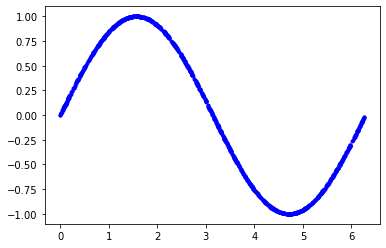

In [4]:
# Number of sample datapoints
SAMPLES = 1000

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values).astype(np.float32)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

## Add noise

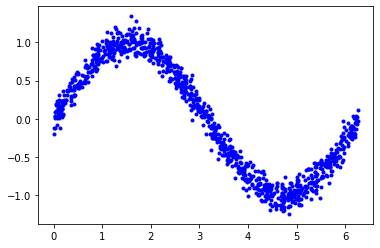

In [5]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

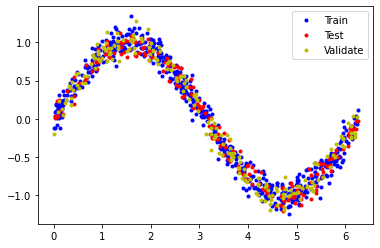

In [6]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()

# Create model schema

In [7]:
split1_model = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
split1_model.add(keras.layers.Dense(16, activation='relu', name="first_layer", input_shape=(1,)))


## Upload weights

In [8]:
split1_model.load_weights("hello_world_model.h5", by_name=True)
split1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer (Dense)         (None, 16)                32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [9]:
split1_model.weights

[<tf.Variable 'first_layer/kernel:0' shape=(1, 16) dtype=float32, numpy=
 array([[-0.39788383,  0.46116257,  0.37156865, -0.07777083, -0.2472133 ,
          0.1315595 ,  0.6120838 , -0.07711333,  0.3081392 ,  0.09540156,
          0.06901786,  0.14382397,  0.50789785,  0.18803696, -0.00574451,
         -0.5632218 ]], dtype=float32)>,
 <tf.Variable 'first_layer/bias:0' shape=(16,) dtype=float32, numpy=
 array([ 0.        ,  0.47112456, -1.0349376 ,  0.        ,  0.        ,
         0.01800696, -0.6069823 ,  0.        , -0.4051201 ,  0.33553302,
         0.78297174,  0.1324779 ,  0.0838714 , -0.15206404,  0.37058446,
         0.        ], dtype=float32)>]

In [10]:
split2_model = tf.keras.Sequential()

# The new second and third layer will help the network learn more complex representations
split2_model.add(keras.layers.Dense(16, activation='relu',name="second_layer",input_shape=(16,)))

# Final layer is a single neuron, since we want to output a single value
split2_model.add(keras.layers.Dense(1,name="output_layer"))

In [11]:
split2_model.load_weights("hello_world_model.h5", by_name=True)
split2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 second_layer (Dense)        (None, 16)                272       
                                                                 
 output_layer (Dense)        (None, 1)                 17        
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [12]:
split2_model.weights

[<tf.Variable 'second_layer/kernel:0' shape=(16, 16) dtype=float32, numpy=
 array([[ 0.00875294, -0.04890293, -0.07921267,  0.42651084,  0.1633878 ,
         -0.13349813, -0.05536762,  0.0875214 , -0.03756449,  0.21884283,
         -0.27020234,  0.04222476,  0.04236186,  0.04289168, -0.19061677,
         -0.33865362],
        [ 0.10046692,  0.23022892, -0.06180466,  0.14322378, -0.17845818,
          0.46872818, -0.33797836,  0.38536182,  0.29767236, -0.20963259,
          0.3055166 , -0.29030812,  0.329263  ,  0.28540763,  0.4265789 ,
          0.23385417],
        [-0.5594068 ,  1.0558994 ,  0.20164725, -0.06504894,  0.41858193,
         -0.9387805 , -0.06396872, -0.17944217, -0.76000506, -0.28421926,
         -0.41786498, -0.11388543,  0.292555  , -0.01116122, -0.9026997 ,
         -0.1418208 ],
        [-0.38656723, -0.13226247,  0.03337517,  0.23714831,  0.03324738,
          0.04901907, -0.40171507,  0.18648282, -0.38397318, -0.33921123,
          0.13673994, -0.22762935,  0.2597

inference count 0------------
x_value = 0.0
0.0
0.47112456
0.0
0.0
0.0
0.018006956
0.0
0.0
0.0
0.33553302
0.78297174
0.1324779
0.0838714
0.0
0.37058446
0.0
{{0.0,0.4711245596408844,0.0,0.0,0.0,0.018006956204771996,0.0,0.0,0.0,0.3355330228805542,0.7829717397689819,0.13247789442539215,0.08387140184640884,0.0,0.3705844581127167,0.0,} 

y_value = 0.029318124055862427
inference count 1------------
x_value = 0.314159265359
0.0
0.61600304
0.0
0.0
0.0
0.059337594
0.0
0.0
0.0
0.3655043
0.80465436
0.17766152
0.24343222
0.0
0.36877978
0.0
{{0.0,0.4711245596408844,0.0,0.0,0.0,0.018006956204771996,0.0,0.0,0.0,0.3355330228805542,0.7829717397689819,0.13247789442539215,0.08387140184640884,0.0,0.3705844581127167,0.0,} 
{0.0,0.6160030364990234,0.0,0.0,0.0,0.059337593615055084,0.0,0.0,0.0,0.36550429463386536,0.8046543598175049,0.17766152322292328,0.24343222379684448,0.0,0.3687797784805298,0.0,} 

y_value = 0.3005623519420624
inference count 2------------
x_value = 0.628318530718
0.0
0.76088154
0.0
0.0
0.

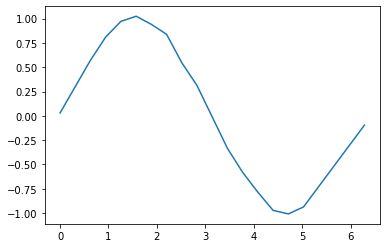

In [13]:
inference_count=0
kInferencesPerCycle = 20
kXrange = 2* 3.14159265359
position=inference_count/kInferencesPerCycle
x_val=position*kXrange
x_list=[]
y_list=[]
st =""
st+="{"
while inference_count <= kInferencesPerCycle:
  position=inference_count/kInferencesPerCycle
  x_val=np.array([[position*kXrange]])
  out_value=split1_model.predict_on_batch(x_val)
  print(f"inference count {inference_count}------------")
  print(f"x_value = {x_val[0][0]}")
  #print(f"salida split: {out_value}")
  
  for x in out_value:
    st+="{"
    for n in x:
      print(n)
      st+=f"{n},"
    st+="} \n"
  print(st)
  
  y_val=split2_model.predict_on_batch(out_value)
  inference_count+=1
  print(f"y_value = {y_val[0][0]}")
  x_list.append(x_val[0][0])
  y_list.append(y_val[0][0])
st+="} \n"

print(st)
plt.plot(x_list,y_list)

In [ ]:
inference_count=0
kInferencesPerCycle = 20
kXrange = 2* 3.14159265359
position=inference_count/kInferencesPerCycle
x_val=position*kXrange
x_list=[]
y_list=[]
st =""
st+="{"
while inference_count <= kInferencesPerCycle:
  position=inference_count/kInferencesPerCycle
  x_val=np.array([[position*kXrange]])
  out_value=split1_model.predict_on_batch(x_val)
  print(f"inference count {inference_count}------------")
  print(f"x_value = {x_val[0][0]}")
  #print(f"salida split: {out_value}")
  
  for x in out_value:
    st+="{"
    for n in x:
      print(n)
      st+=f"{n},"
    st+="} \n"
  print(st)
  
  y_val=split2_model.predict_on_batch(out_value)
  inference_count+=1
  print(f"y_value = {y_val[0][0]}")
  x_list.append(x_val[0][0])
  y_list.append(y_val[0][0])
st+="} \n"

print(st)
plt.plot(x_list,y_list)